# Proyecto de Análisis de datos sobre mi database financiera personal.

A continuación analizaremos distintas métricas sobre una base de datos que he construido a lo largo de algunos años, relacionada a mis gastos financieros. Para este caso, acoté el total de la base de datos y solo utilizare data referente al total del año 2022 y parte del año 2023.

El conocimiento utilizado para llevar a cabo este análisis lo aprendí en el curso 'Manipulación y Transformación de Datos con Pandas y NumPy', en la plataforma educativa Platzi.

## 1: Importar librerías a utilizar

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import random

## 2: Traer nuestra base de datos y convertirla en un dataframe manipulable

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/proyectoDataAnalisis_MiDataFinanciera/finanzas_2022&2023_longformat.csv', encoding='ISO-8859-1')


## 3: Obtener información general de nuestro dataframe

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   year      412 non-null    int64 
 1   month     412 non-null    object
 2   amount    410 non-null    object
 3   item      410 non-null    object
 4   category  411 non-null    object
dtypes: int64(1), object(4)
memory usage: 16.2+ KB
None


In [4]:
df.describe()
#No estamos interesados en estadísticas sobre la columna year, sino la columna amount, la cual no obtenemos porque no es una columna numérica. Corrijamos eso.

,year
count,412.000000
mean,2022.405340
std,0.491555
min,2022.000000
25%,2022.000000
50%,2022.000000
75%,2023.000000
max,2023.000000


Si quisiera convertir los string de la columna 'amount' a enteros, debo limpiar los string de símbolos y espacios.


In [5]:
#Con esta función lambda, retornamos solo los objetos que cumplen la condicion de instancia de la clase str, ya que hay valores nulos.
filtered_df = df[df['amount'].apply(lambda x: isinstance(x,str))]
#Hacemos una copia del dataframe que modificaremos, para no transformar la data al mismo tiempo que la manipulamos.
copy_filtered_df = filtered_df.copy()
#Nos deshacemos del símbolo '$'
copy_filtered_df['amount'] = filtered_df['amount'].apply(lambda x: x[2:])
#Quitamos comas, números luego del punto, y convertimos a integer.
filtered_df['amount'] = copy_filtered_df['amount'].apply(lambda x: int(x.replace('.00','').replace(',','')))

<ipython-input-5-49ef7fc91a85>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['amount'] = copy_filtered_df['amount'].apply(lambda x: int(x.replace('.00','').replace(',','')))


In [6]:
#Consultamos nuevamente esta información general
print(filtered_df.info())
#Podemos ver que 2 entradas fueron eliminadas al momento de filtrar con la condicion isinstance().
print(filtered_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410 entries, 0 to 411
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   year      410 non-null    int64 
 1   month     410 non-null    object
 2   amount    410 non-null    int64 
 3   item      410 non-null    object
 4   category  410 non-null    object
dtypes: int64(2), object(3)
memory usage: 19.2+ KB
None
              year         amount
count   410.000000     410.000000
mean   2022.407317    3306.024390
std       0.491935   16009.413862
min    2022.000000      40.000000
25%    2022.000000     485.000000
50%    2022.000000    1200.000000
75%    2023.000000    2700.000000
max    2023.000000  315000.000000


## 4: Adaptar los números según la inflación acumulada.

In [7]:
#Creamos un diccionario que contenga los datos de inflación acumulada por año y mes.
#Para averiguar hasta que período tenemos información, ejecutamos:
#df[df['year'] == 2022]['month'].unique()
#Lo mismo con el año 2023, y así sabremos hasta que més del año tenemos data
#Utilicé el sitio 'calculadoradeinflacion.com' para averiguar los porcentajes correspondientes

acumulated_inflation = {
    2022: {'enero': 3.12,
           'febrero': 3.00,
           'marzo': 2.87,
           'abril': 2.70,
           'mayo': 2.53,
           'junio': 2.41,
           'julio': 2.29,
           'agosto': 2.13,
           'septiembre': 2,
           'octubre': 1.87,
           'noviembre': 1.76,
           'diciembre': 1.68},
    2023: {'enero': 1.6,
           'febrero':1.51,
           'marzo':1.41,
           'abril':1.31,
           'mayo':1.21,
           'junio':1.12,
           'julio':1.06
    }
}

In [8]:
#Ahora actualizamos nuestro dataframe
updated_inf_df = filtered_df.copy()
#uso int() para convertir los números de punto flotante que obtendré de la multiplicación, a enteros.
updated_inf_df['amount'] = filtered_df.apply(lambda x: int(x['amount'] * acumulated_inflation[x['year']][x['month']]), axis=1)
print(filtered_df['amount'].head(5))
#Comparamos
print(updated_inf_df['amount'].head(5))

0    7690
1     470
2     300
3     200
4     150
Name: amount, dtype: int64
0    23992
1     1466
2      936
3      624
4      468
Name: amount, dtype: int64


## 5.1: Análisis estadístico

Desviación estándar

In [9]:
updated_inf_df['amount'].std()

26028.508194489557

Rango:

In [10]:
updated_inf_df['amount'].max() - updated_inf_df['amount'].min()


503888

Rango interquartil - Interquartile range

In [11]:
min_value = updated_inf_df['amount'].min()
max_value = updated_inf_df['amount'].max()
q1 = updated_inf_df['amount'].quantile(q=0.25)
q2 = updated_inf_df['amount'].quantile(q=0.50)
q3 = updated_inf_df['amount'].quantile(q=0.75)
iqr = q3 - q1
print('min=',min_value,' Q1=',q1,' Q2=',q2,' Q3=',q3,' max=',max_value, ' IQR=',iqr)

min= 112  Q1= 901.75  Q2= 1882.5  Q3= 4668.75  max= 504000  IQR= 3767.0


Si intentamos detectar outliers con el IQR Outlier Detection Method, obtendremos qué el lower_bound es negativo, porque nuestra distribución no es simétrica.

Veamos de manera gráfica cuál es la distribución de nuestros datos.

In [12]:
lower_bound = q1 - iqr * 1.5
upper_bound = q3 + iqr * 1.5
print(lower_bound,upper_bound)

-4748.75 10319.25





## 5.2: Limpieza de datos

Quitamos los outliers.

In [13]:
df_without_outliers = updated_inf_df[(updated_inf_df['amount'] > lower_bound) & (updated_inf_df['amount'] < upper_bound)]


## 6: Visualización de datos

Histograma del dataframe original

<Axes: xlabel='amount', ylabel='Count'>

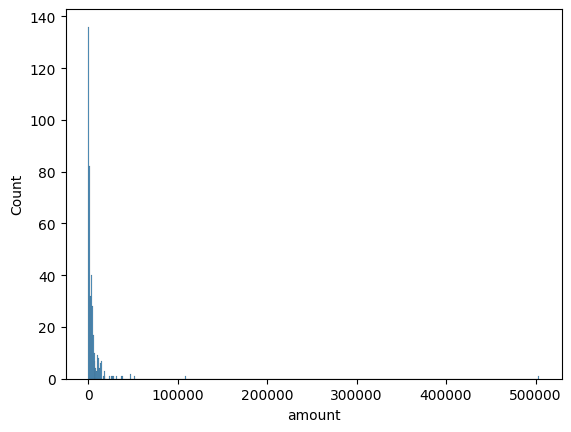

In [14]:
sns.histplot(updated_inf_df['amount'])
#Podemos ver la distribución asimétrica de nuestro dataframe original

Histograma del dataframe sin outliers

<Axes: xlabel='amount', ylabel='Count'>

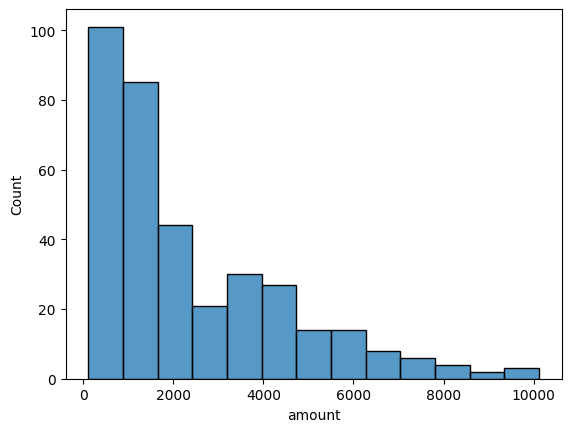

In [15]:
sns.histplot(df_without_outliers['amount'])


Podemos ver un sesgo a la izquierda

Diagrama de caja/Box plot, del dataframe original, en función de los gastos por categoría.

<Axes: xlabel='amount', ylabel='category'>

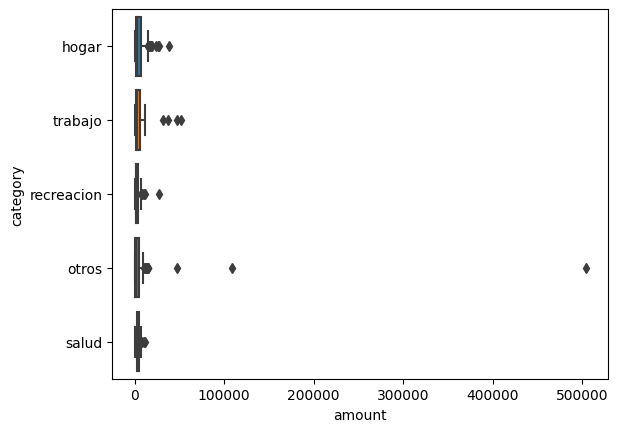

In [16]:
sns.boxplot(y=updated_inf_df['category'],x=updated_inf_df['amount'])

Diagrama de caja / Box plot, del dataframe sin outliers, en función del gasto por categoría

<Axes: xlabel='amount', ylabel='category'>

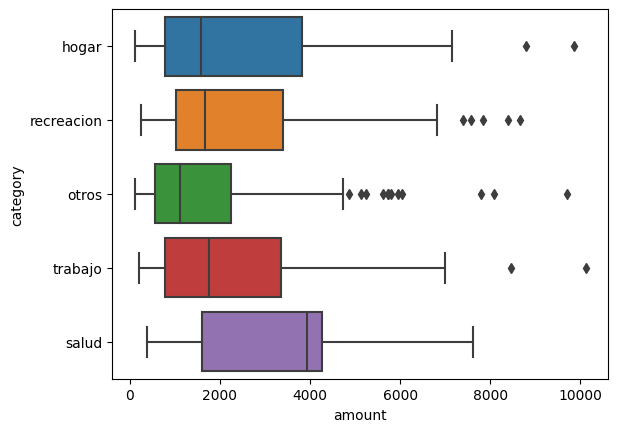

In [17]:
sns.boxplot(y=df_without_outliers['category'],x=df_without_outliers['amount'])


Diagrama de dispersión / Scatter plot

Para usos practicos, ya que esta gráfica no transmitirá información valiosa, añadiré una columna adicional con datos ficticios, que exprese los días del mes.

<Axes: xlabel='amount', ylabel='month_days'>

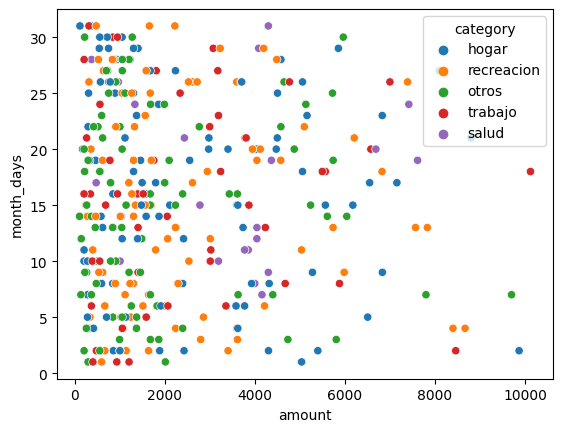

In [46]:
# df_with_month_days = df_without_outliers.copy()
# df_with_month_days['month_days'] = [random.randint(1,31) for x in range(1,360)]
sns.scatterplot(data=df_with_month_days, x='amount', y='month_days',hue='category')
#

Diagrama conjunto / Joint plot

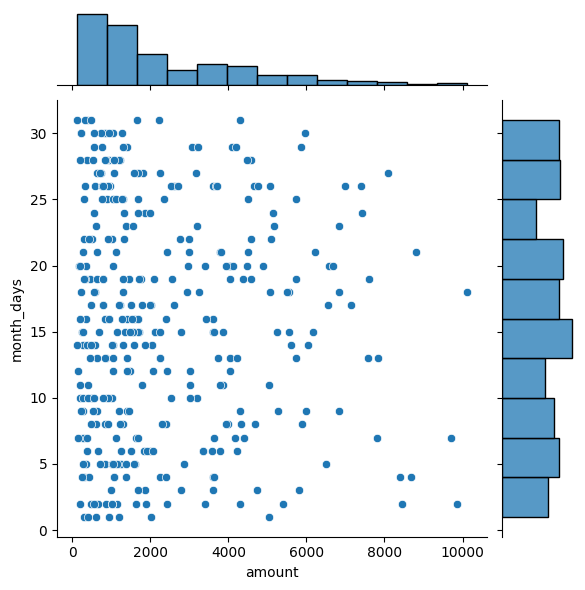

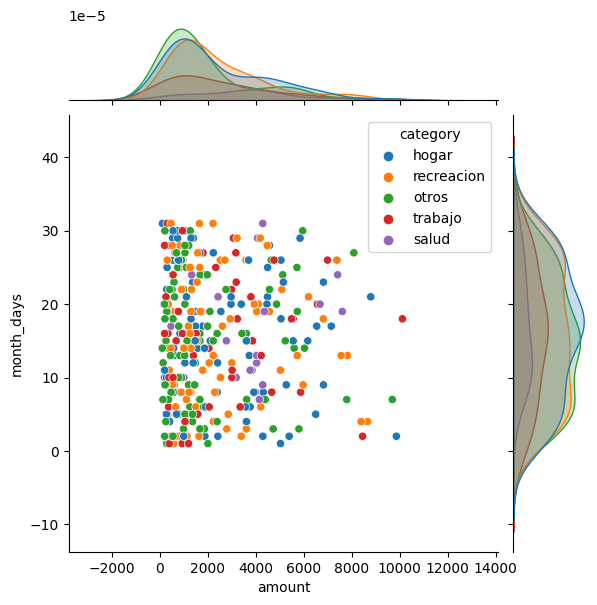

In [49]:
sns.jointplot(data=df_with_month_days, x='amount', y='month_days')
sns.jointplot(data=df_with_month_days, x='amount', y='month_days',hue='category')


